# Reddit upvote prediction

In [33]:
from __future__ import division
import sys
import os

# Dataframe manipulation
import pandas as pd
pd.set_option('max_colwidth', 100)
pd.set_option('display.max_rows', 50) # to see more lines
pd.options.mode.chained_assignment = None  # default='warn'

import pickle

# General
import numpy as np
import math
from collections import Counter
import multiprocessing
from multiprocessing import Pool
import time
from tqdm import tqdm
from itertools import groupby

# Text mining
    # cleaning
import nltk
from nltk import tokenize
from nltk.corpus import stopwords
from spellchecker import SpellChecker
from nltk.stem import WordNetLemmatizer, PorterStemmer
    # tf-idf
from sklearn.feature_extraction.text import TfidfVectorizer
from emoji import UNICODE_EMOJI
from nltk import tokenize
from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer

# Graphs
import networkx as nx

# Plots
import matplotlib.pyplot as plt

# URLs analysis
import re
import urllib.parse
from urllib.parse import urlparse
import math

# for exportation
import csv

from datetime import datetime

In [70]:
nltk.download('wordnet')

[nltk_data] Downloading package wordnet to
[nltk_data]     /Users/guillemforto/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


True

## Reading the data

In [34]:
df = pd.read_csv("comments_students.csv")

In [6]:
len(set(df.link_id))

148848

In [35]:
print(df.shape)
df.head().T

(4234970, 10)


,0,1,2,3,4
created_utc,1430438400,1430438400,1430438400,1430438401,1430438401
ups,3,3,5,1,101
subreddit_id,t5_2qh1i,t5_2qh1i,t5_2qh1i,t5_2qh1i,t5_2qh1i
link_id,t3_34f9rh,t3_34fvry,t3_34ffo5,t3_34aqsn,t3_34f9rh
name,t1_cqug90j,t1_cqug90k,t1_cqug90z,t1_cqug91c,t1_cqug91e
subreddit,AskReddit,AskReddit,AskReddit,AskReddit,AskReddit
id,cqug90j,cqug90k,cqug90z,cqug91c,cqug91e
author,jesse9o3,beltfedshooter,InterimFatGuy,JuanTutrego,dcblackbelt
body,No one has a European accent either because it doesn't exist. There are accents from Europe but...,That the kid ..reminds me of Kevin. so sad :-(,NSFL,I'm a guy and I had no idea this was a thing guys did.,"Mid twenties male rocking skinny jeans/pants, have a styled hair cut, and generally make a stron..."
parent_id,t1_cqug2sr,t3_34fvry,t1_cqu80zb,t1_cqtdj4m,t1_cquc4rc


- **created_utc**: The time of creation in UTC epoch-second format. Note that neither of these ever have a non-zero fraction.
- **ups**: The number of upvotes. (includes own) It is the attribute to be predicted.
- **subreddit_id**: The id of the subreddit in which the thing is located
- **link_id**: ID of the link this comment is in
- **name**: Fullname of comment, e.g.\t1_c3v7f8u"
- **subreddit**: Subreddit of thing excluding the /r/ prex. \pics"
- **id**: This item's identifier, e.g. \8xwlg"
- **author**: The account name of the poster
- **body**: The raw text, this is the unformatted text which includes the raw markup characters such as ** for bold. (<, >, and & are escaped)
- **parent_id**: ID of the thing this comment is a reply to, either the link or comment in it

## Cleaning the data

#### Removing some columns

In [36]:
print("Subreddits:", set(df.subreddit))
print("Subreddit ids:", set(df.subreddit_id))
print("All columns belong to Askreddit subreddit, so we delete them.")
df.drop(['subreddit_id', 'subreddit'], axis=1, inplace=True)

Subreddits: {'AskReddit'}
Subreddit ids: {'t5_2qh1i'}
All columns belong to Askreddit subreddit, so we delete them.


In [74]:
print('% of missing values per variable:')
print(round(df.isna().sum() / len(df) * 100, 2))

% of missing values per variable:
created_utc     0.0
ups            24.0
link_id         0.0
name            0.0
id              0.0
author          0.0
body            0.0
parent_id       0.0
dtype: float64


In [75]:
print('% of null values per variable:')
print(round(df.isnull().sum() / len(df) * 100, 2))

% of null values per variable:
created_utc     0.0
ups            24.0
link_id         0.0
name            0.0
id              0.0
author          0.0
body            0.0
parent_id       0.0
dtype: float64


It's normal to have null/missing values for ups, as this is the test set

#### Removing some rows

In [37]:
# Split into train and test sets (because we only want to remove rows from the train set)
mask = df.ups.isnull()
train = df[~mask]
test = df[mask]
print(f'train length: {len(train)} ({round(len(train)/len(df) * 100, 2)}%)')
print(f'test length: {len(test)} ({round(len(test)/len(df) * 100, 2)}%)')

train length: 3218512 (76.0%)
test length: 1016458 (24.0%)


#### body

Let's remove the comments that were deleted/removed

In [38]:
init = len(train)
train = train[train.body != '']
train = train[train.body != '[removed]']
# train = train[train.body != '[deleted]']
print(f'{init - len(train)} rows were removed ({round((init - len(train))/init * 100,2)} %)')

train.reset_index(inplace=True, drop=True)

12 rows were removed (0.0 %)


In [78]:
empty_in_test = len(test[test.body == ''])
print(f"The test set contains {empty_in_test} rows where body is empty ({round(empty_in_test/len(test) * 100,2)} %)")
removed_in_test = len(test[test.body == '[removed]'])
print(f"The test set contains {removed_in_test} rows where body was removed ({round(removed_in_test/len(test) * 100,2)} %)")
deleted_in_test = len(test[test.body == '[deleted]'])
print(f"The test set contains {deleted_in_test} rows where body was deleted ({round(deleted_in_test/len(test) * 100,2)} %)")
print("We can't remove them for Kaggle prediction.")

The test set contains 0 rows where body is empty (0.0 %)
The test set contains 0 rows where body was removed (0.0 %)
The test set contains 59207 rows where body was deleted (5.82 %)
We can't remove them for Kaggle prediction.


#### author

Let's remove the unknown authors and AutoModerators

In [39]:
init = len(train)
# train = train[train.author != '[deleted]']
# train = train[train.author != 'AutoModerator']
print(f'{init - len(train)} rows were removed ({round((init - len(train))/init * 100,2)} %)')

train.reset_index(inplace=True, drop=True)

0 rows were removed (0.0 %)


In [80]:
autom_in_test = len(test[test.author == 'AutoModerator'])
print(f"The test set contains {autom_in_test} rows where author is AutoModerator ({round(autom_in_test/len(test) * 100,2)} %)")
deleted_in_test = len(test[test.author == '[deleted]'])
print(f"The test set contains {deleted_in_test} rows where author was deleted ({round(deleted_in_test/len(test) * 100,2)} %)")
print("We can't remove them for Kaggle prediction.")

The test set contains 8190 rows where author is AutoModerator (0.81 %)
The test set contains 62620 rows where author was deleted (6.16 %)
We can't remove them for Kaggle prediction.


In [40]:
# Reconcatenating
df = pd.concat([train, test], ignore_index=True)

In [41]:
len(df)

4234958

## Preliminaries

In [17]:
# Basic statistics
print("On average a thread (a discussion) has", round(len(df) / len(set(df.link_id)), 2), "comments.")
print("The average number of comments per author is", round(len(df) / len(set(df.author)), 2))

On average a thread (a discussion) has 28.45 comments.
The average number of comments per author is 7.42


In [18]:
# Structure
print("There are", len(set(df.link_id)), "unique link_ids.")
print("There are", len(df[df.parent_id == None]), "comments that have no parent_id and so are not a reply")

There are 148847 unique link_ids.
There are 0 comments that have no parent_id and so are not a reply


In [42]:
# Types
df['body'] = df['body'].astype(str)

print(df.dtypes)

created_utc      int64
ups            float64
link_id         object
name            object
id              object
author          object
body            object
parent_id       object
dtype: object


## Feature engineering

In [43]:
def parallel_processing(df, func, splitting_field = 'random', func_outputs_df = True):
    """Applies operations in parallel"""
    num_cores = 3
    
    if splitting_field == 'random':
        print('Splitting the dataframe into 100 equal parts. This should be instantaneous.')
        num_partitions = 100
        df_split = np.array_split(df, num_partitions)
    else:
        print(f'Splitting the dataframe by {splitting_field}. This can take several minutes...')
        df_split = [df_i.reset_index(drop=True) for _, df_i in df.groupby(df[splitting_field])]
        
    num_tasks = len(df_split)
    
    print("Parallel processing starts!")
    pool = Pool(num_cores)
    results = []
    for i, _ in enumerate(pool.imap_unordered(func, df_split), 1):
        sys.stderr.write('\rdone {0:%}'.format(i / num_tasks))
        results.append(_)
    
    pool.close()
    pool.join()
    
    if func_outputs_df == False :
        print('Appending everything in a single list')
        final_results = [j for i in results if len(i) > 0 for j in i]
        
        print("Done!")
        return(final_results)
    else:
        print("Concatenating everything in our single dataframe...")
        df = pd.concat(results)
        df.reset_index(inplace=True, drop=True)
    
    print("Done!")
    return(df)

## Content Based Features

- **nb_linked_sr**: number of mentionned subreddits in a comment
- **subjectivity**: number of 'I 's in a comment
- **exclamation**: number of exclamation marks "!" in a comment
- **nb_urls**: number of urls mentionned in a comment
- **nb_pop_urls**: number of popular urls mentionned in a comment (see definition of popular below)
- **word_count**: number of words in a comment
- **vocabulary_richness**: measure for lexical richness
- **is_quoting**: boolean to indicate if the comment is quoting another comment
- **nb_emojis**: number of emojis in the comment

#### nb_linked_sr

In [21]:
def get_nb_linked_sr(df):
    # When a subreddit is mentionned, it appears under the form '/r/' followed by its title
    df['nb_linked_sr'] = df.body.apply(lambda x: len(re.findall(r"/r/([^\s/]+)", str(x)))) # extracts
    df['body'] = df.body.apply(lambda x: re.sub(r"(/r/[^\s/]+)", '', str(x))) # removes subreddits
    print(f'We found {sum(df.nb_linked_sr)} subreddits in total.')
    
    return(df)

In [22]:
df = get_nb_linked_sr(df)

We found 202094 subreddits in total.


#### subjectivity

In [23]:
def get_subjectivity(df):
    df['subjectivity'] = df['body'].str.count('I ')
    print(f"We found {sum(df.subjectivity)} I's in comments.")
    return(df)

In [24]:
df = get_subjectivity(df)

We found 2884138 I's in comments.


#### exclamation

In [25]:
def get_exclamation(df):
    df['exclamation'] = df['body'].str.count('!')
    print(f"We found {sum(df.exclamation)} exclamation marks in all comments.")
    return(df)

In [26]:
df = get_exclamation(df)

We found 533566 exclamation marks in all comments.


#### nb_urls

In [27]:
# Retrieving sites from urls (urls identification)

url_regex = r'http[s]?://(?:[a-zA-Z]|[0-9]|[$-_@.&+]|[!*\(\),]|(?:%[0-9a-fA-F][0-9a-fA-F]))+'

def extract_site(x):
    """
    Extracts a list of sites, each retrieved from its url, from a given comment x"""
    
    # Removing spaces around signs
    x = x.replace(' = ', '=')
    x = x.replace(' : ', ':')
    x = x.replace(' / ', '?')
    urls = re.findall(url_regex, x)
    sites = []
    for url in urls:
        try:
            tmp = urlparse(url).netloc.split('.')
            if 'youtu' in tmp:
                sites.append('youtube')
            elif 'com' in tmp:
                sites.append(tmp[tmp.index('com') - 1])
            elif 'www' in tmp:
                sites.append(tmp[tmp.index('www') + 1])
            else:
                sites.append(tmp[-2])
        except:
            return []
    
    return(sites)


def get_linked_urls(df):
    """ 
    Returns df with an extra column (linked_urls) with a list mentionned of sites"""
    
    df['linked_urls'] = df.body.apply(lambda x: extract_site(str(x)))
    return(df)


def get_nb_urls(df):
    df['nb_urls'] = df['linked_urls'].apply(lambda x: len(x))
    
    return(df)

In [28]:
df = get_linked_urls(df)

In [29]:
df = get_nb_urls(df)

#### nb_pop_urls

In [30]:
def find_most_popular_sites(df):
    """Gets the list of popular urls.
    Popular means that the url is among the 25% most frequently mentionned urls"""
    
    # From list of lists to single list containing everything
    flatten = lambda l: [item for sublist in l for item in sublist]
    list_urls = df.linked_urls
    list_urls = flatten(list_urls)
    list_urls = pd.DataFrame(list_urls)
    list_urls.columns = ["urls"]

    list_urls = list_urls.urls.value_counts().index.tolist()

    # position of 1st quartile (25% of the urls)
    q1 = math.ceil(len(list_urls)/4)

    # get the list of the 25% most popular urls
    top_list_urls = list_urls[:q1]
    print("We retrieved a list of the", len(top_list_urls), 'most popular sites.')
    print('The top 10 is:', top_list_urls[:10])
    
    return(top_list_urls)

In [31]:
top_list_urls = find_most_popular_sites(df)

We retrieved a list of the 4190 most popular sites.
The top 10 is: ['reddit', 'youtube', 'wikipedia', 'imgur', 'google', 'imdb', 'wordpress', 'tumblr', 'xkcd', 'wikimedia']


In [32]:
def get_nb_pop_urls(df):
    """Among the urls cited in a comment, how many are popular"""
    unique_top = set(top_list_urls)
    nb_pop_urls = []
    for i in tqdm(range(len(df))):
        nb_pop_urls.append(len(set(df.loc[i, 'linked_urls']) & unique_top))
        #nb_pop_urls.append(len([el for el in df.loc[i, 'linked_urls'] if el in top_list_urls]))
    
    df["nb_pop_urls"] = nb_pop_urls
    print("Done!")
    
    del df['linked_urls']
      
    return(df)

In [33]:
df = get_nb_pop_urls(df)

100%|██████████| 4234958/4234958 [01:22<00:00, 51475.34it/s]


Done!


In [34]:
def remove_urls(x):
    x = x.replace(' = ', '=')
    x = x.replace(' : ', ':')
    x = x.replace(' / ', '?')
    return(re.sub(url_regex, '', x))

df['body'] = df.body.apply(lambda x: remove_urls(str(x)))

#### word_count

In [35]:
def get_word_count(df):
    df['word_count'] = df.body.apply(lambda x: len(str(x).split()))
    return(df)

In [36]:
df = get_word_count(df)

#### vocabulary_richness

In [37]:
def compute_vocabulary_richness(comment_body):
    """Returns a measure of lexical richness of a list of words based on Yule's I measure (the inverse of Yule's K)"""
    word_list = comment_body.split()
    word_frequencies = {}
    for w in word_list:
        try:
            word_frequencies[w] += 1
        except KeyError:
            word_frequencies[w] = 1
    
    measure1 = float(len(word_frequencies))
    measure2 = sum([len(list(g))*(freq**2) for freq,g in groupby(sorted(word_frequencies.values()))])
    
    # measure1 is the unique number of words
    # measure2 is the sum of the products of each observed frequency to the power of two (freq**2)
    # and the number of words observed with that frequency len(list(g))
    
    try:
        return(round((measure1**2) / (measure2-measure1), 2))
    except ZeroDivisionError:
        return(0)

In [38]:
def get_vocabulary_richness(df):
    #vocabulary_richness = []
    #vocabulary_richness = [compute_vocabulary_richness(i) for i in list_tokens]
    #df['vocabulary_richness'] = vocabulary_richness
    df['vocabulary_richness'] = df.body.apply(lambda x: compute_vocabulary_richness(x))
    return(df)

In [39]:
df = get_vocabulary_richness(df)

#### is_quoting

In [40]:
def get_nb_linked_sr(df):
    # When a comment is mentionning another comment, the reference is under the form '&gt;'
    df['is_quoting'] = df.body.str.contains('&gt;').astype(int) # extracts
    df['body'] = df.body.apply(lambda x: str(x).replace('&gt;', '')) # removes
    print(f'We found {sum(df.is_quoting)} quotations in total.')
    
    return(df)

In [41]:
df = get_nb_linked_sr(df)

We found 70864 quotations in total.


#### nb_emojis

In [42]:
def get_nb_emojis(df):
    df['nb_emojis'] = df.body.apply(lambda x: len([i for i in str(x).split() if i in UNICODE_EMOJI]))
    return(df)

In [43]:
df = parallel_processing(df, get_nb_emojis)
print(f"We found {sum(df.nb_emojis)} on the whole set of comments")

Splitting the dataframe into 100 equal parts. This should be instantaneous.
Parallel processing starts!


done 100.000000%

Concatenating everything in our single dataframe...
Done!
We found 4390 on the whole set of comments


## Text mining Based features

- **token_i**: boolean to indicate if comment contains token_i (adds multiple columns) 

In [44]:
# Tokenize 
def tokenize_comment(df):
    """Returns a list of tokenized comments"""
    tokens = [tokenize.word_tokenize(s) for s in df.body]
    return(tokens)


# Put to lower cases and remove punctuation
def lower_no_punctuation(list_tokens):
    tokens_no_punct_lower = []
    for s in list_tokens: 
        tokens_no_punct_lower.append([w.lower() for w in s if w.isalpha()])
    return(tokens_no_punct_lower)


# Remove stop words
stop_words = stopwords.words('english')
stop_words.extend(["ca","http"])
def no_stop_words(list_tokens):    
    tokens_no_stop_word = []
    for elt in list_tokens: 
        tokens_no_stop_word.append([tok for tok in elt if tok not in stop_words])
    return(tokens_no_stop_word)


# Correct spelling
def reduce_lengthening(text):
    """Ex: skiiin => skin"""
    pattern = re.compile(r"(.)\1{2,}")
    return pattern.sub(r"\1\1", text)


def correct_spelling(list_tokens):
    spell = SpellChecker()
    tokens_corrected = []
    for elt in list_tokens: 
        tokens_corrected.append([reduce_lengthening(word) for word in elt])
    return(tokens_corrected)


# Lemmatize
def lemmatize_tokens(list_tokens):
    lemmatizer = WordNetLemmatizer() 
    tokens_lem = []
    for elt in list_tokens: 
        tokens_lem.append([lemmatizer.lemmatize(tok) for tok in elt])
    return(tokens_lem)


# Stem
def stemming_tokens(list_tokens):
    porter = PorterStemmer()
    stemmed = []
    for elt in list_tokens : 
        stemmed.append([porter.stem(tok) for tok in elt])
    return(stemmed)


# Back to strings
def reverse_tokenize_sentence(sentence):
    sentence_as_string = ''
    for word in sentence:
        sentence_as_string += word + ' '
    return(sentence_as_string.strip())


# Main function for cleaning tokens
def main_cleaning(list_tokens):
    list_tokens = lower_no_punctuation(list_tokens)
    list_tokens = no_stop_words(list_tokens)
    list_tokens = correct_spelling(list_tokens)
    list_tokens = lemmatize_tokens(list_tokens)
    list_tokens = stemming_tokens(list_tokens)
    list_tokens = [reverse_tokenize_sentence(sentence) for sentence in list_tokens]
    return(list_tokens)

In [45]:
# Apply transformations only on comments with ups > 1000 or ups < -100
subdf = df[(df.ups > 1000) | (df.ups < -100)]
subdf['body'].dropna(inplace=True)
subdf.shape

(8327, 8)

In [46]:
tokens_from_subdf = tokenize_comment(subdf)
clean_subdf_body = main_cleaning(tokens_from_subdf)

##### tf_idf

In [47]:
tfidf_vectorizer = TfidfVectorizer(analyzer='word',
                                   max_features=25, # maximum number of words kept per comment
                                   max_df=0.5, # don't keep words which appear in more than 0.5 of the comments
                                   min_df=10) # don't keep words which appear in less than 10 comments

tfidf_vectorizer.fit(clean_subdf_body)

TfidfVectorizer(analyzer='word', binary=False, decode_error='strict',
                dtype=<class 'numpy.float64'>, encoding='utf-8',
                input='content', lowercase=True, max_df=0.5, max_features=25,
                min_df=10, ngram_range=(1, 1), norm='l2', preprocessor=None,
                smooth_idf=True, stop_words=None, strip_accents=None,
                sublinear_tf=False, token_pattern='(?u)\\b\\w\\w+\\b',
                tokenizer=None, use_idf=True, vocabulary=None)

In [48]:
list_tokens = tokenize_comment(df)

In [49]:
len(list_tokens)

4234958

In [50]:
clean_body = pd.DataFrame(main_cleaning(list_tokens))

In [54]:
len(clean_body)

4234958

In [51]:
clean_body.columns = ['body_cleansed']

In [52]:
one_hundred_features = tfidf_vectorizer.transform(clean_body.body_cleansed).toarray()
token_features = pd.DataFrame(one_hundred_features)
token_features.columns = tfidf_vectorizer.get_feature_names()

In [61]:
token_features["id"] = df.id

In [62]:
token_features.to_pickle("token_features.pkl")

## Sentiment Based Features
- **senti_neg**: negative score of comment
- **senti_neu**: neutral score of comment
- **senti_pos**: positive score of comment
- **senti_comp**: compound score of comment

In [10]:
analyser = SentimentIntensityAnalyzer()

In [11]:
def get_sentiments(df):
    df['sentiment'] = df['body'].apply(lambda x: analyser.polarity_scores(x))
    return df

In [ ]:
# takes approx 15 mins
sentiment = parallel_processing(df, get_sentiments)

Splitting the dataframe into 100 equal parts. This should be instantaneous.
Parallel processing starts!


In [ ]:
df['senti_neg'] = sentiment['sentiment'].apply(lambda x: x['neg'])
df['senti_neu'] = sentiment['sentiment'].apply(lambda x: x['neu'])
df['senti_pos'] = sentiment['sentiment'].apply(lambda x: x['pos'])
df['senti_comp'] = sentiment['sentiment'].apply(lambda x: x['compound'])
del sentiment

## Structural features
- **nb_author_thread**: number of unique authors in the link_id of the comment (gives a sense of thread popularity)
- **is_root**: whether or not the parent comment is a direct reply to the first comment of an Askreddit subreddit
- **depth**: depth of a comment in a thread
- **nb_neighbours**: degree (number of neighbours) of a comment in a thread
- **author_centralities (3 measures)**: centrality metrics of the author (intuition: the more connected an author, the more important it is)
- **nb_com_author**: number of comments per author (gives a sense of author activity)
- **order_com**: the rank of the comment based on time
- **parent_score**: the score of the parent of the comment

#### nb_author_thread

For the features to come, we will often need to get a dictionnary from two columns of our pandas DataFrame (one for the keys and the other for some aggregation of the values). Once we have it, we will try to get values based on keys from that dictionnary. Hence, this function will be handy:

In [ ]:
def try_to_get_from_dico(dico, x):
    try:
        return dico[x]
    except:
        return np.nan

In [ ]:
def get_nb_author_thread(df):
    link_id_to_nbauthors = pd.Series(df.author.values, index=df.link_id).groupby(by=['link_id']).count().to_dict()
    df['nb_author_thread'] = df.link_id.apply(lambda x: try_to_get_from_dico(link_id_to_nbauthors, x))
    return(df)

In [ ]:
df = get_nb_author_thread(df)

#### is_root

In [46]:
df['is_root'] = df.parent_id.str.startswith('t3_').astype(int)
print(f'We found {sum(df.is_root)} comments in the root in total ({round(sum(df.is_root) / len(df) * 100, 2)}%).')

We found 1702201 comments in the root in total (40.19%).


#### depth and nb_neighbours

In [54]:
def get_depth_and_nb_neighbours(df):
    """In order to get the depth and the number of neighbours of each comment of the dataframe, 
creates a network from it, where a node is a comment, and two nodes are connected if they have 
a parent-child relationship.

    Parameters:
    df (dataframe)   : dataframe

    Returns:
    df               : dataframe (with depth and nb_neighbours)"""
    
    g = nx.DiGraph()
    g.add_nodes_from(df.link_id, type = "link")
    g.add_nodes_from(df.name, type = "comment")
    g.add_edges_from(df[["parent_id", "name"]].values, linktype = "parent")
    
    df['nb_neighbours'] = [g.degree[n] for n in df['name']]
    df['depth'] = [len(nx.ancestors(g, n)) for n in df['name']]
    
    return df

/Users/guillemforto/anaconda3/lib/python3.7/site-packages/networkx/drawing/nx_pylab.py:579: MatplotlibDeprecationWarning: 
The iterable function was deprecated in Matplotlib 3.1 and will be removed in 3.3. Use np.iterable instead.
  if not cb.iterable(width):
/Users/guillemforto/anaconda3/lib/python3.7/site-packages/networkx/drawing/nx_pylab.py:676: MatplotlibDeprecationWarning: 
The iterable function was deprecated in Matplotlib 3.1 and will be removed in 3.3. Use np.iterable instead.
  if cb.iterable(node_size):  # many node sizes


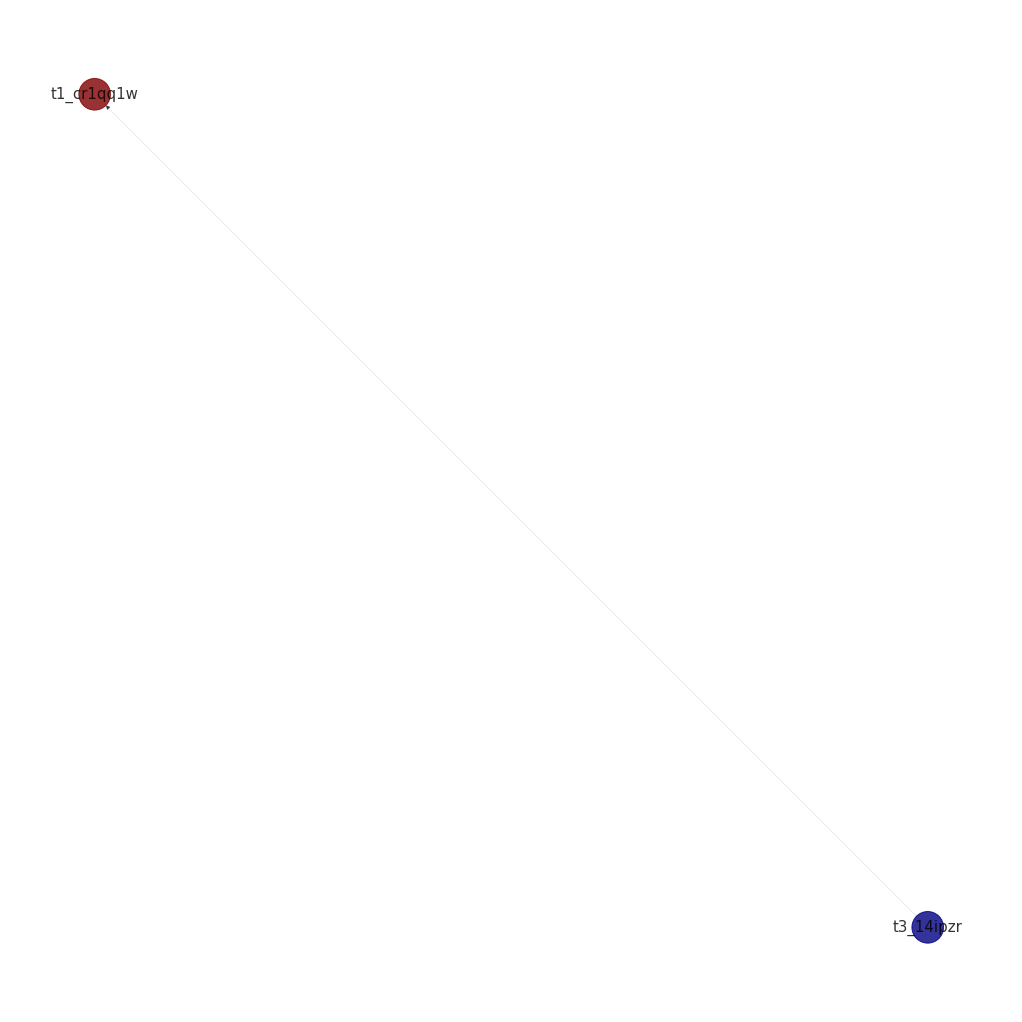

In [55]:
# Plotting 200 nodes of the 1st layer (the comments that were replying to the original comment) of the 1st link_id

# subset
small_df = df[df.link_id == df.link_id[0]]
small_df.reset_index(drop=True, inplace=True)
little_graph = nx.DiGraph()
little_graph.add_nodes_from(small_df.link_id, type = "link")
little_graph.add_nodes_from(small_df.name, type = "comment")
little_graph.add_edges_from(small_df[["parent_id", "name"]].values, linktype = "parent")
    
# prepare options
colorNode = [0]
nodes_to_plot = [df.link_id[0]] # labels
for source, target, attributes in little_graph.edges.data():
    nb_ancestors = len(nx.ancestors(little_graph, target))
    if nb_ancestors <= 1: 
        nodes_to_plot.append(target)
        colorNode.append(nb_ancestors)

nodes_to_plot = nodes_to_plot[:200]
colorNode = colorNode[:200]
super_little_graph = little_graph.subgraph(nodes_to_plot)

# plot
options = {
    'node_color' : colorNode,
    'node_size' : 1000, 
    'cmap' : plt.get_cmap("jet"),
    'node_shape' : 'o',
    'with_labels' : True, 
    "width" : 0.1, 
    "font_size" : 15,
    "nodelist" : nodes_to_plot,
    "alpha" : 0.8   
}

plt.figure(figsize=(14, 14))
nx.draw(super_little_graph, **options)

In [56]:
df = parallel_processing(df, get_depth_and_nb_neighbours, splitting_field = 'link_id')

Splitting the dataframe by link_id. This can take several minutes...
Parallel processing starts!


done 100.000000%

Concatenating everything in our single dataframe...
Done!


#### author_centralities

From Kaggle: "another way to model your data could be to define a user-user undirected network (instead of a comment-comment like we just did). In this network, a node is a user and there exists a link between two users if one has answered a comment from the other.
The idea is to extract communities of users and perhaps calculte some centrality metrics (to get the authority of the author for instance)."

Of course, we also want to take into account the amount of interactions between two users, wo we will add this through a weight attribute in our graph.

We will hence compute the following centrality metrics:
- **degree centrality**: for a node v it's the fraction / the number of nodes it is connected to ;
- **betweenness_centrality**: for a node v it's the fraction / the number of all-pairs shortest paths that pass through v ;
- **eigenvector_centrality**: it computes the centrality of a node based on the centrality of its neighbors (recursive algo) using the adjancecy matrix.

Three remarks:
- Apart from the three metrics, we also tried to compute closeness_centrality, which uses the very greedy (complexity of O(n log(n) + m) with n the number of nodes and m the number of edges) Dijkstra's algorithm to find shortest paths. As our graph isn't connected (see below), NetworkX's algorithm computes it for every connected part, but due to too many nodes, it's too slow. No big deal since we were still able to compute the three others!
- The last two metrics (betweenness and eigenvector centrality) use the weight attribute.
- By default, all metrics are normalized by the number of nodes in the connected part of the graph.

In [47]:
def user_user_network(df):
    sub_df1 = df[['author', 'name']]
    sub_df2 = df[['author', 'parent_id']]

    # We want the intersections with no NA so we choose inner merge
    print('Finding nodes to be connected. This will take a minute...')
    df1_df2_merge = sub_df1.merge(sub_df2, left_on='name', right_on='parent_id', how='inner',
                                  suffixes = ('_parent', '_child'))
    
    # We have parents on the left and childs on the right
    df1_df2_merge = df1_df2_merge.groupby(['author_parent', 'author_child']).aggregate({'author_child':'count'})
    df1_df2_merge.columns = ['counts']
    df1_df2_merge.reset_index(level=0, drop=False, inplace=True)
    df1_df2_merge.reset_index(level=0, drop=False, inplace=True)
    
    nodes_to_be_connected = df1_df2_merge.values
    
    # Graph (Undirected)
    g = nx.Graph() # Undirected Simple type
    g.add_weighted_edges_from(nodes_to_be_connected)
    print('Graph created!')
    return(g)

In [48]:
def get_author_centralities(df):
    degree_centralities = []
    betweenness_centralities = []
    eigenvector_centralities = []
    
    print("Getting degree centralities...")
    deg = nx.degree_centrality(authors_graph)
    
    print("Getting eigenvector centralities...")    
    eig = nx.eigenvector_centrality(authors_graph, weight = 'weight')
    
    print("Getting betweenness centralities...")
    print("We use 50 nodes to estimate betweenness centrality so you might want to go for a coffee :D")
    bet = nx.betweenness_centrality(authors_graph, k = 50, weight = 'weight', normalized = True)
    
    #print("Getting closeness centralities...")
    #clo = nx.closeness_centrality(authors_graph, distance = 'weight', wf_improved = True)
    
    print("Appending the features...")
    all_nodes = authors_graph.nodes
    deg_mean = int(pd.Series([*deg.values()]).mean())
    eig_mean = int(pd.Series([*eig.values()]).mean())
    bet_mean = int(pd.Series([*bet.values()]).mean())
    for i in df.author :
        if i in all_nodes:
            degree_centralities.append(deg[i])
            eigenvector_centralities.append(eig[i])
            betweenness_centralities.append(bet[i])
        else:
            degree_centralities.append(deg_mean)
            eigenvector_centralities.append(eig_mean)
            betweenness_centralities.append(bet_mean)
    
    df['degree_centrality'] = degree_centralities
    df['betweenness_centrality'] = betweenness_centralities
    df['eigenvector_centrality'] = eigenvector_centralities
    
    print("Done!")
    return(df)

In [57]:
authors_graph = user_user_network(df)

Finding nodes to be connected. This will take a minute...
Graph created!


In [58]:
if nx.is_connected(authors_graph) == False :
    print('The graph is not connected.')
else: 
    print('The graph is connected.')

The graph is not connected.


In [ ]:
df = get_author_centralities(df)

#### nb_com_author
In the case of nb_com_author, the keys of the dico will be our author names, and the values will be a counting of the number of comments they made. A remark: AutoModerator couldn't be removed on the cleaning phase because it is in some rows of the test, and so in order not to dramatically increase the variance of our feature, we will replace the real value by the median ourselves.

In [50]:
def get_nb_com_author(df):
    author_to_nbcoms = pd.Series(df.name.values, index=df.author).groupby(by=['author']).count().to_dict()
    author_to_nbcoms['AutoModerator'] = pd.Series([*author_to_nbcoms.values()]).median() # median replacement
    df['nb_com_author'] = df.author.apply(lambda x: try_to_get_from_dico(author_to_nbcoms, x))
    return(df)

In [51]:
df = get_nb_com_author(df)

#### order_com

In [52]:
def get_order_com(df):
    """Gets the order of apparition (i.e. rank) of each comment, inside a thread, based on time it was published.
This rank is then divided by the length of the thread to normalize the values.
Two comments with same publication time will have the same order.

    Parameters:
    df (dataframe)   : dataframe

    Returns:
    df               : dataframe (with order_com)"""
    
    timestamps = df.created_utc.tolist()
    s = sorted(timestamps)
    df['order_com'] = [s.index(x) for x in timestamps]
    
    return(df)

In [53]:
df = parallel_processing(df, get_order_com, splitting_field = 'link_id')

Splitting the dataframe by link_id. This can take several minutes...
Parallel processing starts!


done 100.000000%

Concatenating everything in our single dataframe...
Done!


#### parent_score

To get the parent_score, we get a dictionary with the scores of every comment. Then, for every parent_id, we try to find it among the keys od the dictionary (the names), and get the score. Of course, some comments don't have a parent, so in this case we simply decided to use median imputation (mean was too high as it is too sensible to extreme values).

In [60]:
def get_parent_score(df):
    comment_to_score = pd.Series(df['ups'].values, index=df['name']).to_dict() # dictionary
    df['parent_score'] = df.parent_id.apply(lambda x: try_to_get_from_dico(comment_to_score, x))
    # fill nas
    med = df.parent_score.median()
    df.parent_score.fillna(med, inplace=True)
    return(df)

In [61]:
df = get_parent_score(df)

## Time based features

- **time_lapse**: time since publication of first comment in thread
- **hour**: hour of the day the comment was posted
- **weekday**: day of the week the comment was published
- **time_since_parent**: the elapsed time between the post publication and the parent publication.

In [62]:
# Convert created_utc to datetime
df['time'] = pd.to_datetime(df.created_utc, unit='s')

#### time_lapse
First of all, we will create a dictionary with publication times for first comment(s) in each thread.
Then, we will try to get the time difference between comment publication and first comment publication.
We didn't have any NA (logically, as there is always a first comment), so no need for median or mean imputation here.

In [63]:
def get_time_lapse(df):
    df_first_comment_dict = df[['link_id', 'time']].groupby(by=['link_id']).min().to_dict('index') # dictionary
    df['time_lapse'] = df.time - df.link_id.apply(lambda x: df_first_comment_dict[x]['time'])
    df.time_lapse = df.time_lapse.apply(lambda x: x.total_seconds())
    return(df)

In [64]:
df = get_time_lapse(df)

#### hour and weekday

In [65]:
df['hour'] = df.time.apply(lambda x: x.hour)
df['weekday'] = df.time.dt.weekday

#### time_since_parent

Our appracoh here will be similar to what we did with time_lapse. It will consist in creating a dictionary with all times for each comment (i.e. for each name) at first.
Then, we will try to get the publication time of the parent.
Of course, if the parent_id does not correspond to any name, then time_since_parent will be missing. In that case, we will assume that if the time is missing, it means that the comment does not have a parent. Hence we will simply replace missing values by publication time, so that afterwards, when we compute the differences between both values, we will have time_since_parent = 0 seconds.

In [66]:
def get_time_since_parent(df):
    times_for_each_comment = pd.Series(df.time.values, index=df.name).to_dict()
    df['time_since_parent'] = df.parent_id.apply(lambda x: try_to_get_from_dico(times_for_each_comment, x))
    df.loc[df.time_since_parent.isna(), 'time_since_parent'] = df.time
    df.time_since_parent = df.time - df.time_since_parent
    df.time_since_parent = df.time_since_parent.apply(lambda x: x.total_seconds())
    return(df)

In [67]:
df = get_time_since_parent(df)

The modelisation part will be in the other notebook

In [68]:
df.to_pickle("df_v13.pkl")